# Prerequisite:
## 1) The dataset should be in .csv format
## 2) The dataset should contain casesensitive 'Date' and 'Close'.
## 3) 'Date' should be in the format of yyyy-dd-mm, if the format is different then the actual formate is specified in the places where 'format=' codes are commented.
## 4) Here we have taken CSV from https://data.nasdaq.com/data/BSE/BOM500570-tata-motors-ltd-eod-prices

### Here we have imported all library and modules which are necessary in our project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler       #Transform features by scaling each feature to a given range. It is used here in KNN and LSTM.
from fastai.tabular.core import add_datepart         #Helper function that adds columns relevant to a date in the column. Here it is used in
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV     #GridSearch is used here in KNN, SVM and Randomforest to find the best parameter.
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# 1)  Data Loading

### Here we have taken the latest .csv file dataset of TATA MOTORS LTD. and try to predict next few days price.

In [2]:
df = pd.read_csv('tata.csv')    # Dataset
X_future = df[['Date']]         
X_future = X_future[0:10]       # it is used to select the last 10 days price of the selected stock

In [3]:
df.shape

(7607, 13)

In [4]:
# Output variable: Close(Datatype: float64)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7607 entries, 0 to 7606
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       7607 non-null   object 
 1   Open                       7607 non-null   float64
 2   High                       7607 non-null   float64
 3   Low                        7607 non-null   float64
 4   Close                      7607 non-null   float64
 5   WAP                        7607 non-null   float64
 6   No. of Shares              7607 non-null   float64
 7   No. of Trades              7607 non-null   float64
 8   Total Turnover             7607 non-null   float64
 9   Deliverable Quantity       5029 non-null   float64
 10  % Deli. Qty to Traded Qty  5029 non-null   float64
 11  Spread H-L                 7607 non-null   float64
 12  Spread C-O                 7607 non-null   float64
dtypes: float64(12), object(1)
memory usage: 772.7+ K

In [5]:
df.head()

,Date,Open,High,Low,Close,WAP,No. of Shares,No. of Trades,Total Turnover,Deliverable Quantity,% Deli. Qty to Traded Qty,Spread H-L,Spread C-O
0,2022-05-26,421.4,422.55,404.95,420.70,414.20,1167082.0,24443.0,483402074.0,327447.0,28.06,17.60,-0.70
1,2022-05-25,428.8,428.95,413.60,417.05,419.93,509378.0,8254.0,213903135.0,106642.0,20.94,15.35,-11.75
2,2022-05-24,422.3,427.50,416.00,425.60,422.00,1123617.0,22290.0,474166530.0,372537.0,33.16,11.50,3.30
3,2022-05-23,421.1,431.10,419.70,421.60,424.70,693741.0,11490.0,294635127.0,124833.0,17.99,11.40,0.50
4,2022-05-20,410.0,421.35,409.20,417.95,417.54,1687548.0,32120.0,704612468.0,695716.0,41.23,12.15,7.95


In [6]:
df.describe()

,Open,High,Low,Close,WAP,No. of Shares,No. of Trades,Total Turnover,Deliverable Quantity,% Deli. Qty to Traded Qty,Spread H-L,Spread C-O
count,7607.000000,7607.000000,7607.000000,7607.000000,7607.000000,7.607000e+03,7607.000000,7.607000e+03,5.029000e+03,5029.000000,7607.000000,7607.000000
mean,391.243914,397.622157,384.161319,390.622249,345.846838,1.046049e+06,9021.339424,3.305041e+08,3.312898e+05,26.847035,13.460839,-0.621664
std,240.017572,243.302173,236.000844,239.552761,269.111064,1.907824e+06,11423.624310,7.600210e+08,1.512832e+06,14.669304,11.488963,10.506088
min,59.000000,60.500000,58.000000,58.850000,0.000000,0.000000e+00,0.000000,0.000000e+00,3.133000e+03,2.890000,0.000000,-97.800000
25%,199.000000,203.050000,193.325000,197.550000,141.857860,2.430575e+05,2270.000000,7.354580e+07,9.689500e+04,16.470000,6.400000,-4.950000
50%,357.500000,364.000000,350.700000,357.000000,311.600000,6.071340e+05,6259.000000,2.125200e+08,1.810670e+05,24.360000,10.100000,-0.450000
75%,495.000000,502.475000,487.000000,494.350000,474.116821,1.276294e+06,11942.000000,4.078045e+08,3.408030e+05,34.290000,16.500000,3.800000
max,1365.450000,1381.400000,1346.800000,1365.600000,1363.673006,8.410000e+07,166088.000000,3.807770e+10,8.376508e+07,304.280000,229.900000,78.200000


# 2) Data Preprocessing (Handle Missing values, Sorting)

In [7]:
# Check for Missing values in data
df[(df.isna().any(axis=1))]

,Date,Open,High,Low,Close,WAP,No. of Shares,No. of Trades,Total Turnover,Deliverable Quantity,% Deli. Qty to Traded Qty,Spread H-L,Spread C-O
1599,2015-12-09,402.4,404.85,392.85,393.95,397.930000,470588.0,7449.0,187260567.0,NaN,NaN,12.00,-8.45
3389,2008-09-15,400.0,405.00,383.25,390.60,390.409112,260061.0,4775.0,101530184.0,NaN,NaN,21.75,-9.40
3390,2008-09-12,430.0,430.00,403.00,411.85,422.696295,273894.0,3866.0,115773979.0,NaN,NaN,27.00,-18.15
3391,2008-09-11,430.0,437.00,413.05,424.15,422.052693,199058.0,3310.0,84012965.0,NaN,NaN,23.95,-5.85
3392,2008-09-10,416.5,421.45,416.05,418.55,418.040204,113595.0,2786.0,47487277.0,NaN,NaN,5.40,2.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7602,1991-01-11,170.0,175.00,167.50,175.00,0.000000,0.0,0.0,0.0,NaN,NaN,7.50,5.00
7603,1991-01-09,177.5,177.50,167.50,171.25,0.000000,0.0,0.0,0.0,NaN,NaN,10.00,-6.25
7604,1991-01-07,170.0,177.50,167.50,176.25,0.000000,0.0,0.0,0.0,NaN,NaN,10.00,6.25
7605,1991-01-03,175.0,182.50,175.00,182.50,0.000000,0.0,0.0,0.0,NaN,NaN,7.50,7.50


In [8]:
df = df.dropna()

## 2.1) Data Visualization

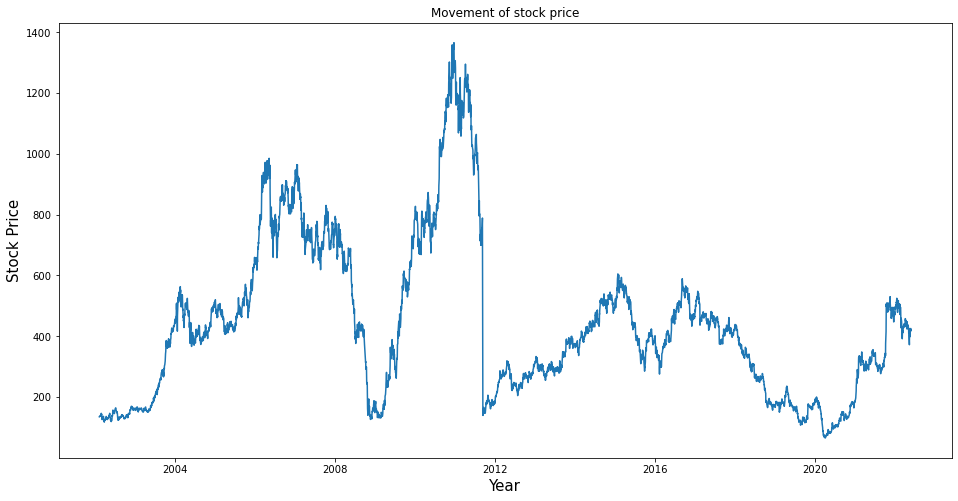

In [9]:
# setting index as date
# Here if the csv file contain date in the formate %Y-%m-%d then it is default otherwise we have to use (formate = the formate Date is in %d/%m/%y)

df.index = pd.to_datetime(df.Date)    #format='%m/%d/%Y'

plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')
plt.xlabel('Year', fontsize=15)
plt.ylabel('Stock Price', fontsize=15)
plt.title('Movement of stock price')
plt.show()

In [10]:
sorted_df = df.sort_index(ascending=True, axis=0)
sorted_df.head()

,Date,Open,High,Low,Close,WAP,No. of Shares,No. of Trades,Total Turnover,Deliverable Quantity,% Deli. Qty to Traded Qty,Spread H-L,Spread C-O
Date,,,,,,,,,,,,,
2002-02-08,2002-02-08,138.00,140.5,134.00,135.10,137.573524,550807.0,4728.0,75776460.0,80314.0,14.58,6.50,-2.9
2002-02-15,2002-02-15,142.75,144.5,138.25,138.95,140.700633,1304457.0,7242.0,183537925.0,367425.0,28.17,6.25,-3.8
2002-02-18,2002-02-18,140.00,141.5,136.25,137.90,138.244919,313058.0,2174.0,43278678.0,111392.0,35.58,5.25,-2.1
2002-02-19,2002-02-19,137.50,142.0,136.20,136.80,139.466944,736870.0,4155.0,102769007.0,195980.0,26.60,5.80,-0.7
2002-02-20,2002-02-20,137.00,138.9,135.00,136.90,137.311892,363260.0,2654.0,49879918.0,70573.0,19.43,3.90,-0.1


## 2.2) Feature Selection

In [11]:
data = pd.DataFrame(columns=['Date', 'Close'])

data['Date'] = sorted_df['Date'].values
data['Close'] = sorted_df['Close'].values

data.head()

,Date,Close
0,2002-02-08,135.10
1,2002-02-15,138.95
2,2002-02-18,137.90
3,2002-02-19,136.80
4,2002-02-20,136.90


In [12]:
# Adding new features

add_datepart(data, 'Date')
data.index = sorted_df.index
data.drop('Elapsed', axis=1, inplace=True)    #elapsed will be the time stamp (hh:mm:ss) i.e here it will be 1.653523e+09
data.head()

,Close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
Date,,,,,,,,,,,,,
2002-02-08,135.10,2002,2,6,8,4,39,False,False,False,False,False,False
2002-02-15,138.95,2002,2,7,15,4,46,False,False,False,False,False,False
2002-02-18,137.90,2002,2,8,18,0,49,False,False,False,False,False,False
2002-02-19,136.80,2002,2,8,19,1,50,False,False,False,False,False,False
2002-02-20,136.90,2002,2,8,20,2,51,False,False,False,False,False,False


## 2.3) Split Data into Training and Testing Datasets (80:20)

In [13]:
ratio = 0.2
label = data['Close']
features = data.drop('Close', axis=1)
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=ratio, shuffle=False)
X_train.head()

,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
Date,,,,,,,,,,,,
2002-02-08,2002,2,6,8,4,39,False,False,False,False,False,False
2002-02-15,2002,2,7,15,4,46,False,False,False,False,False,False
2002-02-18,2002,2,8,18,0,49,False,False,False,False,False,False
2002-02-19,2002,2,8,19,1,50,False,False,False,False,False,False
2002-02-20,2002,2,8,20,2,51,False,False,False,False,False,False


In [14]:
X_future_common = X_future.copy(deep=True)
X_future_common.head()

,Date
0,2022-05-26
1,2022-05-25
2,2022-05-24
3,2022-05-23
4,2022-05-20


In [15]:
index = pd.to_datetime(X_future_common['Date'])    #format='%m/%d/%Y'
add_datepart(X_future_common, 'Date')
X_future_common.index = index
X_future_common.drop('Elapsed', axis=1, inplace=True)
X_future_common.head()

,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
Date,,,,,,,,,,,,
2022-05-26,2022,5,21,26,3,146,False,False,False,False,False,False
2022-05-25,2022,5,21,25,2,145,False,False,False,False,False,False
2022-05-24,2022,5,21,24,1,144,False,False,False,False,False,False
2022-05-23,2022,5,21,23,0,143,False,False,False,False,False,False
2022-05-20,2022,5,20,20,4,140,False,False,False,False,False,False


# 3)Train Data on Machine Learning Models

## 3.1)Linear Regression

In [16]:
#implement linear regression
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [17]:
# make predictions
preds_train = model.predict(X_train)
preds = model.predict(X_test)

# R-square
r2_linear_test = r2_score(y_test, preds)
print('R-Square on test set: ', r2_linear_test)

r2_linear_train = r2_score(y_train, preds_train)
print('R-Square on train set: ', r2_linear_train)

# MAE
mae_linear_test = mean_absolute_error(y_test, preds)
print('MAE on test set: ', mae_linear_test)

mae_linear_train = mean_absolute_error(y_train, preds_train)
print('MAE on train set: ', mae_linear_train)

# RMSE
rms_linear_test = mean_squared_error(y_test, preds, squared=False)
print('RMSE on test set: ', rms_linear_test)

rms_linear_train = mean_squared_error(y_train, preds_train, squared=False)
print('RMSE on train set: ', rms_linear_train)

R-Square on test set:  -4.809720114072207
R-Square on train set:  0.009144013038139609
MAE on test set:  267.2046971430177
MAE on train set:  203.1816199436293
RMSE on test set:  290.30710754029343
RMSE on train set:  259.92371935206336


In [18]:
y_train_pred_lr = pd.DataFrame(columns=['Predictions'])
y_train_pred_lr['Predictions'] = preds_train
y_train_pred_lr.index = y_train.index

y_test_pred_lr = pd.DataFrame(columns=['Predictions'])
y_test_pred_lr['Predictions'] = preds
y_test_pred_lr.index = y_test.index

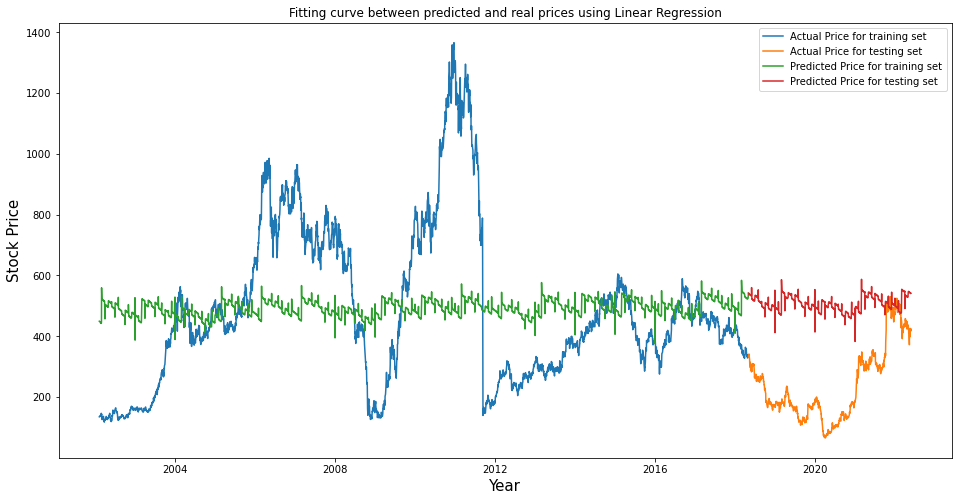

In [19]:
plt.figure(figsize=(16,8))
plt.plot(y_train, label='Actual Price for training set')
plt.plot(y_test, label='Actual Price for testing set')
plt.plot(y_train_pred_lr, label='Predicted Price for training set')
plt.plot(y_test_pred_lr, label='Predicted Price for testing set')
plt.xlabel('Year', fontsize=15)
plt.ylabel('Stock Price', fontsize=15)
plt.title('Fitting curve between predicted and real prices using Linear Regression')
plt.legend()

plt.show()

In [20]:
# predicting future price using Linear Regression
future_preds_lr = model.predict(X_future_common)
future_preds_lr

array([541.23217843, 540.98076033, 540.72934224, 540.47792414,
       543.56030712, 543.30888902, 543.05747092, 542.80605282,
       542.55463472, 545.6370177 ])

## 3.2) k-Nearest Neighbors(KNN)

In [21]:
# scaling data
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled)
X_test_scaled = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test_scaled)
X_future_common_scaled = scaler.fit_transform(X_future_common)
X_future_common = pd.DataFrame(X_future_common_scaled)

In [22]:
# using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
clf = GridSearchCV(knn, params, cv=5)    #cross-validation

# fit the model and make predictions
search = clf.fit(X_train,y_train)

model = search.best_estimator_ 
print(model)

KNeighborsRegressor(n_neighbors=9)


In [23]:
preds = model.predict(X_test)
preds_train = model.predict(X_train)

# R-square
r2_knn_test = r2_score(y_test, preds)
print('R-Square on test set: ', r2_knn_test)

r2_knn_train = r2_score(y_train, preds_train)
print('R-Square on train set: ', r2_knn_train)

# MAE
mae_knn_test = mean_absolute_error(y_test, preds)
print('MAE on test set: ', mae_knn_test)

mae_knn_train = mean_absolute_error(y_train, preds_train)
print('MAE on train set: ', mae_knn_train)

# RMSE
rms_knn_test = mean_squared_error(y_test, preds, squared=False)
print('RMSE on test set: ', rms_knn_test)

rms_knn_train = mean_squared_error(y_train, preds_train, squared=False)
print('RMSE on train set: ', rms_knn_train)

R-Square on test set:  -7.975386737186378
R-Square on train set:  0.4919670249830832
MAE on test set:  285.09376518665783
MAE on train set:  132.5948366338001
RMSE on test set:  360.8333321214191
RMSE on train set:  186.11723631063134


In [24]:
y_test_pred_knn = pd.DataFrame(columns=['Predictions'])
y_test_pred_knn['Predictions'] = preds
y_test_pred_knn.index = y_test.index

y_train_pred_knn = pd.DataFrame(columns=['Predictions'])
y_train_pred_knn['Predictions'] = preds_train
y_train_pred_knn.index = y_train.index

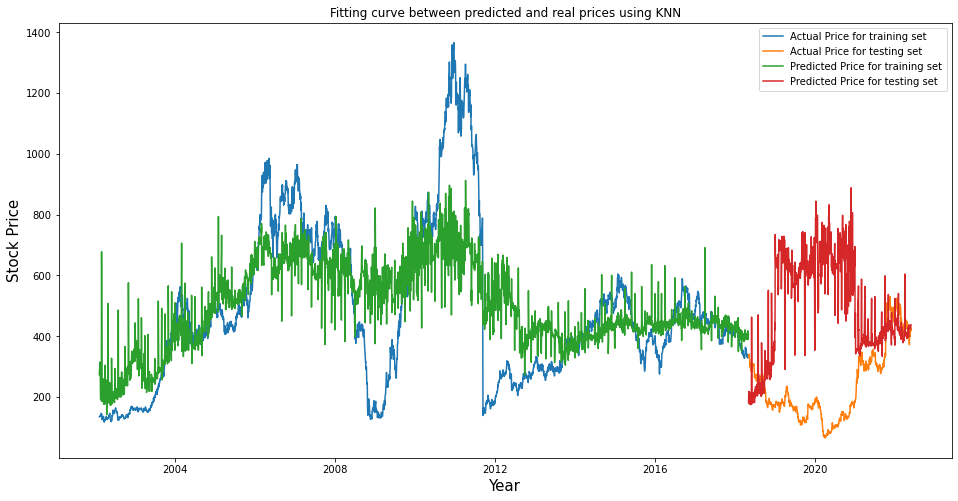

In [25]:
plt.figure(figsize=(16,8))
plt.plot(y_train, label='Actual Price for training set')
plt.plot(y_test, label='Actual Price for testing set')
plt.plot(y_train_pred_knn, label='Predicted Price for training set')
plt.plot(y_test_pred_knn, label='Predicted Price for testing set')
plt.xlabel('Year', fontsize=15)
plt.ylabel('Stock Price', fontsize=15)
plt.title('Fitting curve between predicted and real prices using KNN')
plt.legend()

plt.show()

In [26]:
# predicting future price using K-Nearest Neighbour
future_preds_knn = model.predict(X_future_common)
future_preds_knn

array([283.        , 251.29444444, 247.82222222, 228.18333333,
       289.39444444, 254.05555556, 217.68888889, 187.69444444,
       269.43888889, 401.83333333])

## 3.3) SVM (Support Vector Machine)

In [27]:
params = {'C': [0.001, 0.01, 0.1], 'kernel': ['linear', 'rbf'], 'gamma': [0.001, 0.01, 0.1]}
svm = SVR()
clf = GridSearchCV(svm, params, cv=5)
search = clf.fit(X_train, y_train)
model = search.best_estimator_
print(model)

SVR(C=0.001, gamma=0.001)


In [28]:
preds = model.predict(X_test)
preds_train = model.predict(X_train)

# R-square
r2_svm_test = r2_score(y_test, preds)
print('R-Square on test set: ', r2_svm_test)

r2_svm_train = r2_score(y_train, preds_train)
print('R-Square on train set: ', r2_svm_train)

# MAE
mae_svm_test = mean_absolute_error(y_test, preds)
print('MAE on test set: ', mae_svm_test)

mae_svm_train = mean_absolute_error(y_train, preds_train)
print('MAE on train set: ', mae_svm_train)

# RMSE
rms_svm_test = mean_squared_error(y_test, preds, squared=False)
print('RMSE on test set: ', rms_svm_test)

rms_svm_train = mean_squared_error(y_train, preds_train, squared=False)
print('RMSE on train set: ', rms_svm_train)

R-Square on test set:  -2.611942071447361
R-Square on train set:  -0.045405822308152155
MAE on test set:  205.3055319931087
MAE on train set:  195.3395568325797
RMSE on test set:  228.90245559094657
RMSE on train set:  266.98268798725536


In [29]:
y_test_pred_svm = pd.DataFrame(columns=['Predictions'])
y_test_pred_svm['Predictions'] = preds
y_test_pred_svm.index = y_test.index

y_train_pred_svm = pd.DataFrame(columns=['Predictions'])
y_train_pred_svm['Predictions'] = preds_train
y_train_pred_svm.index = y_train.index

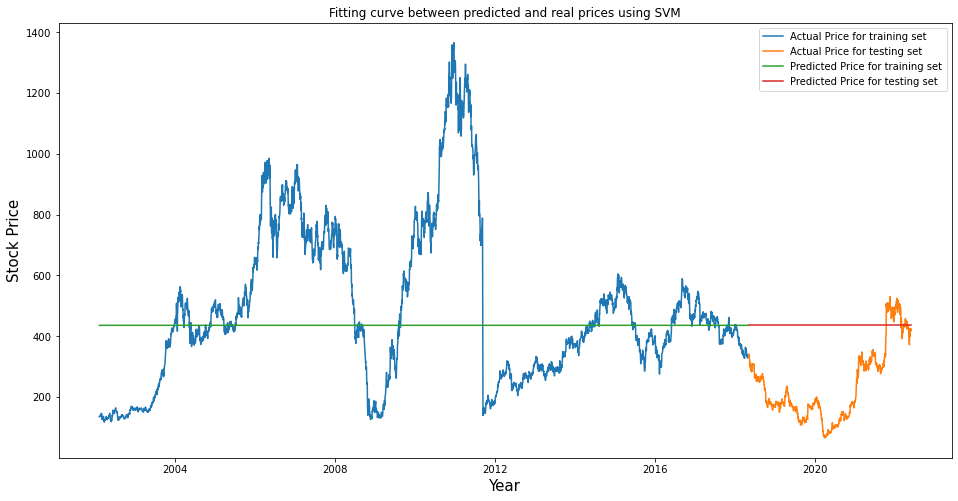

In [30]:
plt.figure(figsize=(16,8))
plt.plot(y_train, label='Actual Price for training set')
plt.plot(y_test, label='Actual Price for testing set')
plt.plot(y_train_pred_svm, label='Predicted Price for training set')
plt.plot(y_test_pred_svm, label='Predicted Price for testing set')
plt.xlabel('Year', fontsize=15)
plt.ylabel('Stock Price', fontsize=15)
plt.title('Fitting curve between predicted and real prices using SVM')
plt.legend()

plt.show()

In [31]:
# predicting future price using Support Vector Machine
future_preds_svm = model.predict(X_future_common)
future_preds_svm

array([435.99990972, 435.99991503, 435.99992034, 435.99992564,
       436.00000447, 436.00000981, 436.00001514, 436.00002046,
       436.00002575, 436.00010442])

## 3.4) Random Forest

In [32]:
params = {'n_estimators': [100, 200, 300], 'max_features': ['auto', 'sqrt']}
random_forest = RandomForestRegressor(random_state=42)    #Controls both the randomness of the bootstrapping of the samples used when building trees
clf = GridSearchCV(random_forest, params, n_jobs=5, cv=5)
search = clf.fit(X_train, y_train)
model = search.best_estimator_
print(model)

RandomForestRegressor(max_features='sqrt', random_state=42)


In [33]:
preds = model.predict(X_test)
preds_train = model.predict(X_train)

# R-square
r2_rf_test = r2_score(y_test, preds)
print('R-Square on test set: ', r2_rf_test)

r2_rf_train = r2_score(y_train, preds_train)
print('R-Square on train set: ', r2_rf_train)

# MAE
mae_rf_test = mean_absolute_error(y_test, preds)
print('MAE on test set: ', mae_rf_test)

mae_rf_train = mean_absolute_error(y_train, preds_train)
print('MAE on train set: ', mae_rf_train)

# RMSE
rms_rf_test = mean_squared_error(y_test, preds, squared=False)
print('RMSE on test set: ', rms_rf_test)

rms_rf_train = mean_squared_error(y_train, preds_train, squared=False)
print('RMSE on train set: ', rms_rf_train)

R-Square on test set:  -11.775526381362972
R-Square on train set:  0.9754340724525925
MAE on test set:  335.2424045725647
MAE on train set:  28.937902187422303
RMSE on test set:  430.49634147272917
RMSE on train set:  40.92674704725879


In [34]:
y_test_pred_rf = pd.DataFrame(columns=['Predictions'])
y_test_pred_rf['Predictions'] = preds
y_test_pred_rf.index = y_test.index

y_train_pred_rf = pd.DataFrame(columns=['Predictions'])
y_train_pred_rf['Predictions'] = preds_train
y_train_pred_rf.index = y_train.index

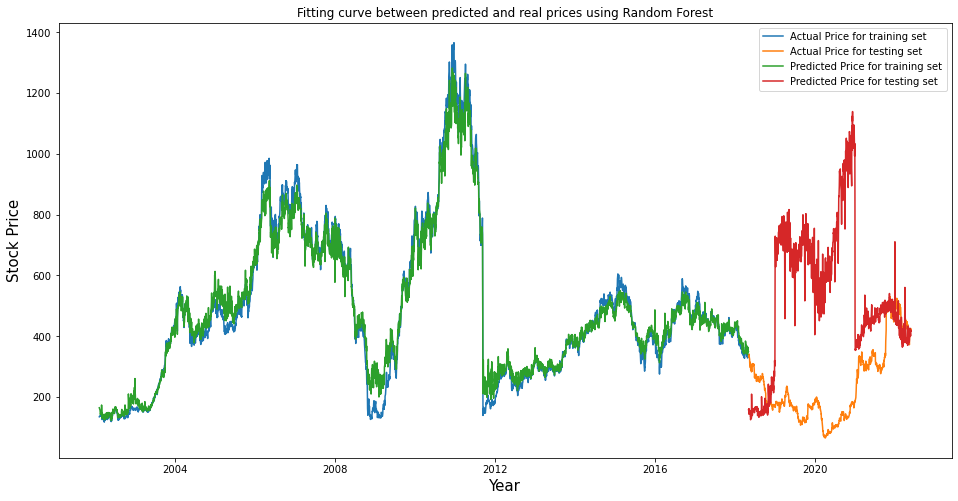

In [35]:
plt.figure(figsize=(16,8))
plt.plot(y_train, label='Actual Price for training set')
plt.plot(y_test, label='Actual Price for testing set')
plt.plot(y_train_pred_rf, label='Predicted Price for training set')
plt.plot(y_test_pred_rf, label='Predicted Price for testing set')
plt.xlabel('Year', fontsize=15)
plt.ylabel('Stock Price', fontsize=15)
plt.title('Fitting curve between predicted and real prices using Random Forest')
plt.legend()

plt.show()

In [36]:
# predicting future price using Random Forest
future_preds_rf = model.predict(X_future_common)
future_preds_rf

array([253.4635, 213.725 , 225.281 , 227.846 , 196.388 , 168.5015,
       153.1005, 169.296 , 158.289 , 222.8715])

## 3.5) LSTM(Long - Short Term Memory)

In [37]:
data = pd.DataFrame(columns=['Date', 'Close'])

data['Date'] = sorted_df['Date'].values
data['Close'] = sorted_df['Close'].values
data.index = pd.to_datetime(data['Date'])
data.drop('Date', axis=1, inplace=True)

data.tail()

,Close
Date,
2022-05-20,417.95
2022-05-23,421.60
2022-05-24,425.60
2022-05-25,417.05
2022-05-26,420.70


In [38]:
dataset = data.values
dataset

array([[135.1 ],
       [138.95],
       [137.9 ],
       ...,
       [425.6 ],
       [417.05],
       [420.7 ]])

In [39]:
train_df, test_df = train_test_split(data, test_size=ratio, shuffle=False)
train_size = train_df.shape[0]

In [40]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.05367992],
       [0.05664078],
       [0.05583327],
       ...,
       [0.2770899 ],
       [0.2705145 ],
       [0.27332154]])

In [41]:
# converting dataset into X_train and y_train
X_train, y_train = [], []
sequence_len = 60
for i in range(sequence_len, train_size):
    X_train.append(scaled_data[i-sequence_len:i, 0])
    y_train.append(scaled_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(3963, 60, 1)

In [42]:
# create and fit the LSTM network

neurons = [50]
minimum = 100000
preds = []
best_model = Sequential()
for i, n in enumerate(neurons):
  model = Sequential()
  model.add(LSTM(units=n, return_sequences=True, input_shape=(X_train.shape[1],1)))
  model.add(LSTM(units=n))
  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
  model.fit(X_train, y_train, epochs=1, batch_size=1, validation_split=0.1)

  inputs = data[len(data) - len(test_df) - sequence_len:].values
  inputs = inputs.reshape(-1,1)
  inputs  = scaler.transform(inputs)

  # predicting closing price for test set, using past 60 values from the train data
  X_test_i = []
  for i in range(len(test_df)):
      X_test_i.append(inputs[i:i+sequence_len, 0])
  X_test_i = np.array(X_test_i)
  X_test_i = np.reshape(X_test_i, (X_test_i.shape[0], X_test_i.shape[1], 1))

  preds = model.predict(X_test_i)
  preds = scaler.inverse_transform(preds)

  rms = rms = mean_squared_error(test_df.values, preds, squared=False)
  if rms < minimum:
    minimum = rms
    best_preds = preds 
    best_model = model

rms_lstm_test = minimum
preds = best_preds
model = best_model

32/32 [==============================] - 1s 14ms/step


In [43]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [44]:
inputs_t = data.values
inputs_t = inputs_t.reshape(-1,1)
inputs_t  = scaler.transform(inputs_t)

# predicting closing price for train set
Xt = []
for i in range(len(train_df)-sequence_len):
    Xt.append(inputs_t[i:i+sequence_len, 0])
Xt = np.array(Xt)
Xt = np.reshape(Xt, (Xt.shape[0], Xt.shape[1], 1))

preds_train = model.predict(Xt)
preds_train = scaler.inverse_transform(preds_train)

rms_lstm_train = np.sqrt(np.mean(np.power((train_df.values[sequence_len:] - preds_train),2)))
print('RMSE on train set: ', rms_lstm_train)

124/124 [==============================] - 2s 17ms/step
RMSE on train set:  24.23778087868788


In [45]:
# R-square
r2_lstm_test = r2_score(test_df.values, preds)
print('R-Square on test set: ', r2_lstm_test)

r2_lstm_train = r2_score(train_df.values[sequence_len:], preds_train)
print('R-Square on train set: ', r2_lstm_train)

# MAE
mae_lstm_test = mean_absolute_error(test_df.values, preds)
print('MAE on test set: ', mae_lstm_test)

mae_lstm_train = mean_absolute_error(train_df.values[sequence_len:], preds_train)
print('MAE on train set: ', mae_lstm_train)

# RMSE
rms_lstm_test = mean_squared_error(test_df.values, preds, squared=False)
print('RMSE on test set: ', rms_lstm_test)

rms_lstm_train = mean_squared_error(train_df.values[sequence_len:], preds_train, squared=False)
print('RMSE on train set: ', rms_lstm_train)

R-Square on test set:  0.988006775218535
R-Square on train set:  0.9912624679326566
MAE on test set:  10.319738347866899
MAE on train set:  14.614927452716927
RMSE on test set:  13.190098846987832
RMSE on train set:  24.23778087868788


In [46]:
for i in range(sequence_len):
  preds_train = np.concatenate([[dataset[i]], preds_train])

In [47]:
# Predict price for n next days

n = 10
X_future_test = []
for i in range(0, n):
  X_future_test.append(inputs[-sequence_len:, 0])
  X_future_test_arr = np.array(X_future_test)
  X_future_test_arr = np.reshape(X_future_test_arr, (X_future_test_arr.shape[0], X_future_test_arr.shape[1], 1))
  
  nextday_closing_price = model.predict(X_future_test_arr)
  inputs = np.append(inputs, nextday_closing_price, 0)

nextday_closing_price = scaler.inverse_transform(nextday_closing_price)

1/1 [==============================] - 0s 35ms/step


In [48]:
nextday_closing_price

array([[427.92886],
       [429.56915],
       [433.21228],
       [436.227  ],
       [438.46057],
       [441.03906],
       [443.68976],
       [446.4371 ],
       [449.37253],
       [452.4863 ]], dtype=float32)

In [49]:
future_df = X_future.copy(deep=True)
index = pd.to_datetime(future_df['Date'])    #format='%m/%d/%Y'
future_df.index = index
future_df.drop('Date', axis=1, inplace=True)

In [50]:
test_df['Predictions'] = preds
train_df['Predictions'] = preds_train
#future_df['Predictions'] = nextday_closing_price

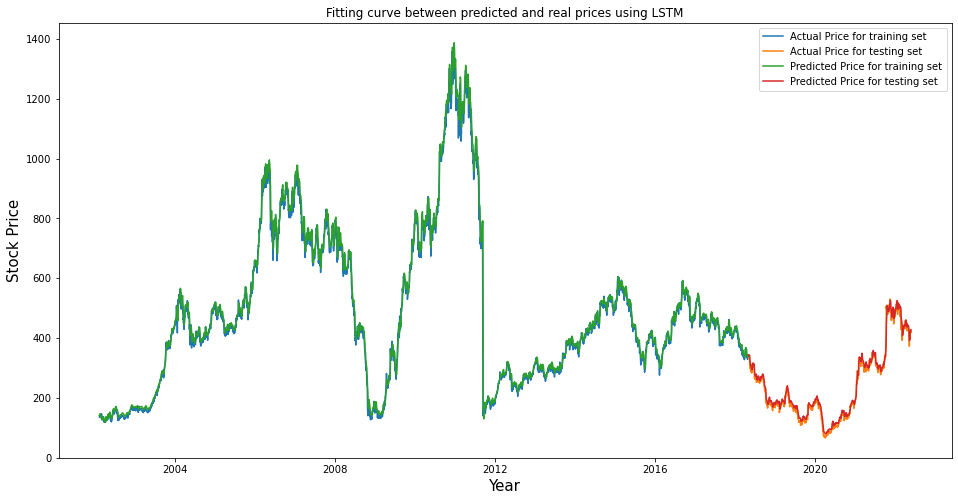

In [51]:
plt.figure(figsize=(16,8))
plt.plot(train_df['Close'], label='Actual Price for training set')
plt.plot(test_df['Close'], label='Actual Price for testing set')
plt.plot(train_df['Predictions'], label='Predicted Price for training set')
plt.plot(test_df['Predictions'], label='Predicted Price for testing set')
#plt.plot(future_df['Predictions'], label='Predicted Price for future set')
plt.xlabel('Year', fontsize=15)
plt.ylabel('Stock Price', fontsize=15)
plt.title('Fitting curve between predicted and real prices using LSTM')
plt.legend()

plt.show()

## Compare performance (Error values of all the algorithms)

In [52]:
new_df = pd.DataFrame({"Method":["Linear Regression", "KNN", "SVM", "Random Forest", "LSTM"],
                       "R-Square Error(Training)": [r2_linear_train, r2_knn_train, r2_svm_train, r2_rf_train, r2_lstm_train],
                        "R-Square Error(Testing)": [r2_linear_test, r2_knn_test, r2_svm_test, r2_rf_test, r2_lstm_test],
                       "Mean Absolute Error(Training)": [mae_linear_train, mae_knn_train, mae_svm_train, mae_rf_train, mae_lstm_train],
                        "Mean Absolute Square Error(Testing)": [mae_linear_test, mae_knn_test, mae_svm_test, mae_rf_test, mae_lstm_test],
                       "Root Mean Square Error(Training)": [rms_linear_train, rms_knn_train, rms_svm_train, rms_rf_train, rms_lstm_train],
                        "Root Mean Square Error(Testing)": [rms_linear_test, rms_knn_test, rms_svm_test, rms_rf_test, rms_lstm_test],
                       })
new_df

,Method,R-Square Error(Training),R-Square Error(Testing),Mean Absolute Error(Training),Mean Absolute Square Error(Testing),Root Mean Square Error(Training),Root Mean Square Error(Testing)
0,Linear Regression,0.009144,-4.809720,203.181620,267.204697,259.923719,290.307108
1,KNN,0.491967,-7.975387,132.594837,285.093765,186.117236,360.833332
2,SVM,-0.045406,-2.611942,195.339557,205.305532,266.982688,228.902456
3,Random Forest,0.975434,-11.775526,28.937902,335.242405,40.926747,430.496341
4,LSTM,0.991262,0.988007,14.614927,10.319738,24.237781,13.190099


# 4) Predict price for future dates

In [53]:
new_df = pd.DataFrame({"Days": ['Day1','Day2','Day3','Day4','Day5','Day6','Day7','Day8','Day9','Day10'],
                       "Linear Regression": future_preds_lr,
                       "KNN": future_preds_knn,
                       "SVM": future_preds_svm,
                       "Random Forest": future_preds_rf,
                       "LSTM": nextday_closing_price.flatten()
                       })
new_df

,Days,Linear Regression,KNN,SVM,Random Forest,LSTM
0,Day1,541.232178,283.000000,435.999910,253.4635,427.928864
1,Day2,540.980760,251.294444,435.999915,213.7250,429.569153
2,Day3,540.729342,247.822222,435.999920,225.2810,433.212280
3,Day4,540.477924,228.183333,435.999926,227.8460,436.226990
4,Day5,543.560307,289.394444,436.000004,196.3880,438.460571
5,Day6,543.308889,254.055556,436.000010,168.5015,441.039062
6,Day7,543.057471,217.688889,436.000015,153.1005,443.689758
7,Day8,542.806053,187.694444,436.000020,169.2960,446.437103
8,Day9,542.554635,269.438889,436.000026,158.2890,449.372528
9,Day10,545.637018,401.833333,436.000104,222.8715,452.486298
